### Выбран датасет, в котором предлагается выяснить зависимость успеваемости студентов (exam_score) от различных факторов в их жизни таких как: количество учебных часов, посещение лекций, время сна, питание, время на социальные сети, фильмы и развлечения.

### Поскольку я сам студент мне это интересно и полезно.

### https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance

### Целевая функция: exam_score, задача регрессии
### Размер: 1000 экземпляров, 14 признаков

In [ ]:
import kagglehub
jayaantanaath_student_habits_vs_academic_performance_path = kagglehub.dataset_download('jayaantanaath/student-habits-vs-academic-performance')

print('Data source import complete.')


Data source import complete.


In [ ]:
import pandas as pd
import numpy as np

import torch
from torchsummary import summary

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/kaggle/input/student-habits-vs-academic-performance/student_habits_performance.csv')

In [ ]:
print(data.head())

  student_id  age  gender  study_hours_per_day  social_media_hours  \
0      S1000   23  Female                  0.0                 1.2   
1      S1001   20  Female                  6.9                 2.8   
2      S1002   21    Male                  1.4                 3.1   
3      S1003   23  Female                  1.0                 3.9   
4      S1004   19  Female                  5.0                 4.4   

   netflix_hours part_time_job  attendance_percentage  sleep_hours  \
0            1.1            No                   85.0          8.0   
1            2.3            No                   97.3          4.6   
2            1.3            No                   94.8          8.0   
3            1.0            No                   71.0          9.2   
4            0.5            No                   90.9          4.9   

  diet_quality  exercise_frequency parental_education_level internet_quality  \
0         Fair                   6                   Master          Average  

In [ ]:
# Проверка на неопределённые данные
print(data.isna().sum())

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64


In [ ]:
print(data['parental_education_level'].unique())
data['parental_education_level'] = data['parental_education_level'].fillna('None')
print(data['parental_education_level'].unique())

['Master' 'High School' 'Bachelor' nan]
['Master' 'High School' 'Bachelor' 'None']


In [ ]:
# Замена категориальных признаков на числовые
mapping_dict = {'Master': 3, 'Bachelor': 2, 'High School': 1, 'None': 0}
data['parental_education_level_factorized'] = data['parental_education_level'].map(mapping_dict)
print(data['parental_education_level_factorized'].unique())

[3 1 2 0]


In [ ]:
# Подготовка загружаемого в нейросеть датасета, замена категориальных признаков
df = data.drop(columns=['student_id', 'parental_education_level'])
string_columns = df.select_dtypes(include=['object']).columns
for col in string_columns:
    print(col, df[col].unique())

df['part_time_job'], _ = df['part_time_job'].factorize()
df['extracurricular_participation'], _ = df['extracurricular_participation'].factorize()
df['gender'], _ = df['gender'].factorize()

diet_quality_mapping_dict = {'Good': 3, 'Fair': 2, 'Poor': 1}
internet_quality_mapping_dict = {'Good': 3, 'Average': 2, 'Poor': 1}

df['diet_quality']= df['diet_quality'].map(diet_quality_mapping_dict)
df['internet_quality']= df['internet_quality'].map(internet_quality_mapping_dict)

print('\n\n\n')

for col in string_columns:
    print(col, df[col].unique())



gender ['Female' 'Male' 'Other']
part_time_job ['No' 'Yes']
diet_quality ['Fair' 'Good' 'Poor']
internet_quality ['Average' 'Poor' 'Good']
extracurricular_participation ['Yes' 'No']




gender [0 1 2]
part_time_job [0 1]
diet_quality [2 3 1]
internet_quality [2 1 3]
extracurricular_participation [0 1]


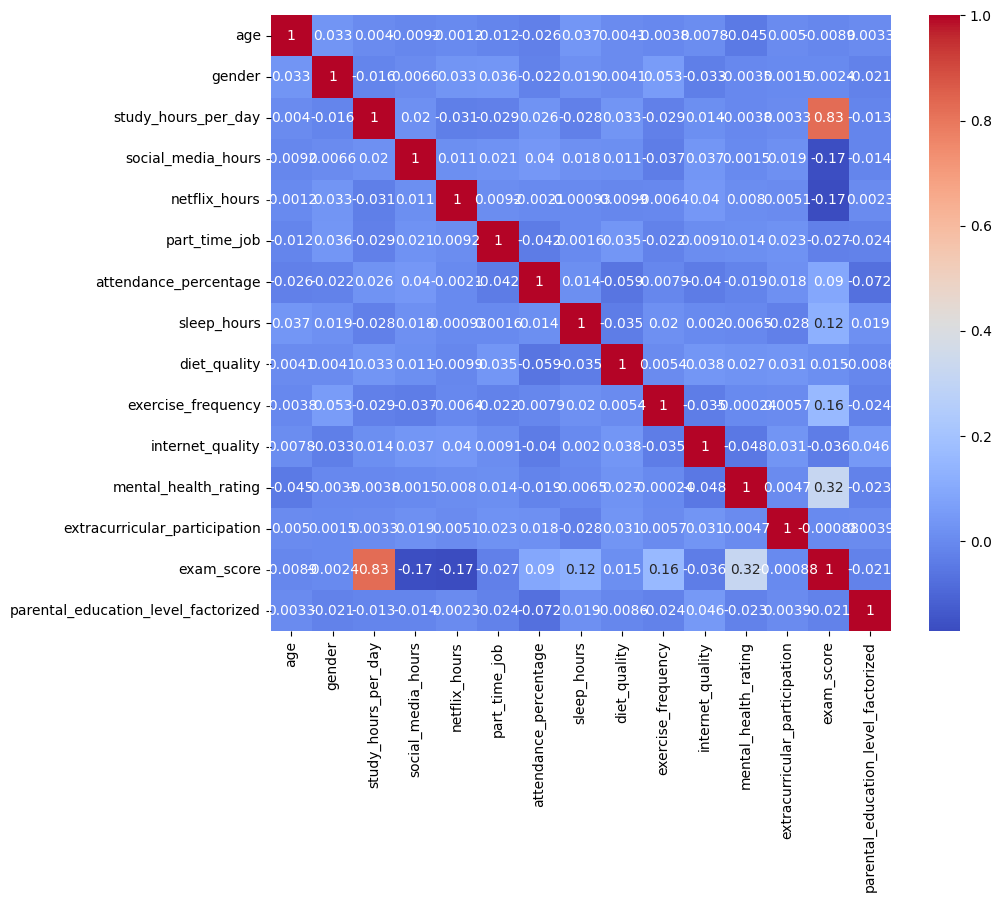

In [ ]:
# Построение матрицы корреляций
correlation_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

### Можно заметить, что наибольшая корреляция наблюдается у 7 признаков: количество часов обучения в день, время на фильмы, социальные сети, сон, посещаемость занятий, частота упражнений, состояние ментального здоровья.

In [ ]:
print(len(df.iloc[0]))

15


In [ ]:
# Отбор признаков с наибольшей корреляцией
df = df[['study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage',\
         'sleep_hours', 'exercise_frequency', 'mental_health_rating', 'exam_score']]

print(len(df.iloc[0]))

8


In [ ]:
# Разделение на X и y
features = df.drop(columns=['exam_score']).values
target = df['exam_score'].values

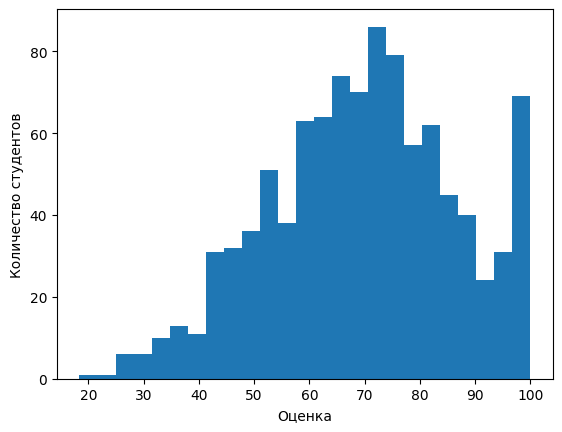

In [ ]:
# Диаграмма для анализа распределения оценок
plt.hist(target, bins=25)
plt.xlabel("Оценка")
plt.ylabel("Количество студентов")
plt.show()

In [ ]:
# Стандартизация признаков
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [ ]:
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(target, dtype=torch.float32)

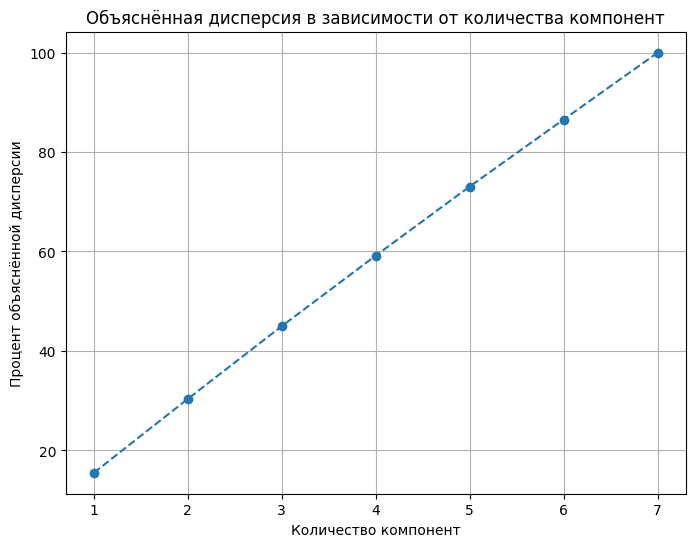

In [ ]:
# Проверка, может можно ещё что-то убрать без больших потерь (видно, что нельзя)

pca = PCA(random_state=42).fit(X_tensor)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1),
         explained_variance_ratio.cumsum() * 100,
         marker='o',
         linestyle='--')
plt.xlabel('Количество компонент')
plt.ylabel('Процент объяснённой дисперсии')
plt.title('Объяснённая дисперсия в зависимости от количества компонент')
plt.grid(True)
plt.show()

In [ ]:
# Разбиение выборки на тренировочную и тестовую
train_idx, test_idx = train_test_split(
    range(len(target)), test_size=0.1, random_state=42
)

In [ ]:
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
train_data = torch.utils.data.Subset(dataset, train_idx)
test_data = torch.utils.data.Subset(dataset, test_idx)

In [ ]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Нейросеть: так как всего получилось 7 признаков, то вероятно достаточно простой нейросети с небольшим числом параметров
### Так как поставлена задача регрессии, то оценка для эпохи на тестовой выборке будет производится  через ошибку L1Loss и среднее от средних относительных отклонений от правильного ответа в каждом пакете (avg_special_loss).

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, train_loader, test_loader):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(7, 100)
        self.relu1 = torch.nn.LeakyReLU()
        self.dropout1 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(100, 50)
        self.relu2 = torch.nn.LeakyReLU()
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc3 = torch.nn.Linear(50, 1)

        self.train_loader = train_loader
        self.test_loader = test_loader

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

    def train_model(self, optimizer, criterion, num_epochs):
        self.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                optimizer.zero_grad()

                outputs = self(inputs)
                loss = criterion(outputs.squeeze(), labels.squeeze())

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(self.train_loader):.4f}, Test loss, Avg_Div: {self.evaluate_model()}")


    def evaluate_model(self):
        self.eval()
        running_loss = 0.0
        with torch.no_grad():
            correct = 0
            total = 0
            avg_special_loss = 0
            for inputs, labels in self.test_loader:
                outputs = self(inputs).squeeze()
                avg_special_loss += sum(torch.abs(outputs.squeeze() - labels) / labels)/labels.size()[0]
                loss = criterion(outputs, labels.squeeze())
                running_loss += loss.item()

            return f'{running_loss / len(self.train_loader):.4f}, {100*avg_special_loss/len(self.train_loader):.4f}%'

    def show_results(self):
        self.eval()
        with torch.no_grad():
            outputs = []
            targets = []
            for inputs, labels in self.test_loader:
                outputs += self(inputs).squeeze()
                targets += labels

        plt.figure(figsize=(12, 8))
        plt.plot(np.array(targets), alpha=0.5, label='Целевое значение', color='green')
        plt.plot(np.array(outputs), alpha=0.5, label='Предсказания', color='red')
        plt.ylabel("Оценка")
        plt.legend()
        plt.grid()
        plt.ylim(0, 105)
        plt.show()

        plt.hist(np.array(targets), alpha=0.5, label='Целевое значение', color='green')
        plt.hist(np.array(outputs), alpha=0.5, label='Предсказания', color='red')
        plt.show()

In [ ]:
model = Net(train_loader, test_loader)
print(summary(model, (1, 7)))

criterion = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Уменьшение скорости обучения при подходе к минимуму по экспоненциальной зависимости
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]             800
         LeakyReLU-2               [-1, 1, 100]               0
           Dropout-3               [-1, 1, 100]               0
            Linear-4                [-1, 1, 50]           5,050
         LeakyReLU-5                [-1, 1, 50]               0
           Dropout-6                [-1, 1, 50]               0
            Linear-7                 [-1, 1, 1]              51
Total params: 5,901
Trainable params: 5,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03
----------------------------------------------------------------
None


In [ ]:
model.train_model(optimizer, criterion, 50)

Epoch [1/50], Loss: 68.0412, Test loss, Avg_Div: 7.8175, 11.2906%
Epoch [2/50], Loss: 54.9876, Test loss, Avg_Div: 4.6920, 6.5270%
Epoch [3/50], Loss: 20.7558, Test loss, Avg_Div: 1.3872, 2.2752%
Epoch [4/50], Loss: 9.5563, Test loss, Avg_Div: 1.1902, 1.8901%
Epoch [5/50], Loss: 8.8793, Test loss, Avg_Div: 1.1754, 1.8484%
Epoch [6/50], Loss: 8.4125, Test loss, Avg_Div: 1.0763, 1.7338%
Epoch [7/50], Loss: 7.9449, Test loss, Avg_Div: 1.0433, 1.6739%
Epoch [8/50], Loss: 7.6021, Test loss, Avg_Div: 0.9968, 1.6091%
Epoch [9/50], Loss: 7.1767, Test loss, Avg_Div: 0.9461, 1.5412%
Epoch [10/50], Loss: 6.8548, Test loss, Avg_Div: 0.9292, 1.4974%
Epoch [11/50], Loss: 6.7432, Test loss, Avg_Div: 0.8852, 1.4312%
Epoch [12/50], Loss: 6.3746, Test loss, Avg_Div: 0.8528, 1.3942%
Epoch [13/50], Loss: 6.0975, Test loss, Avg_Div: 0.8236, 1.3436%
Epoch [14/50], Loss: 5.8823, Test loss, Avg_Div: 0.8106, 1.3395%
Epoch [15/50], Loss: 5.6553, Test loss, Avg_Div: 0.7845, 1.2837%
Epoch [16/50], Loss: 5.4332, T

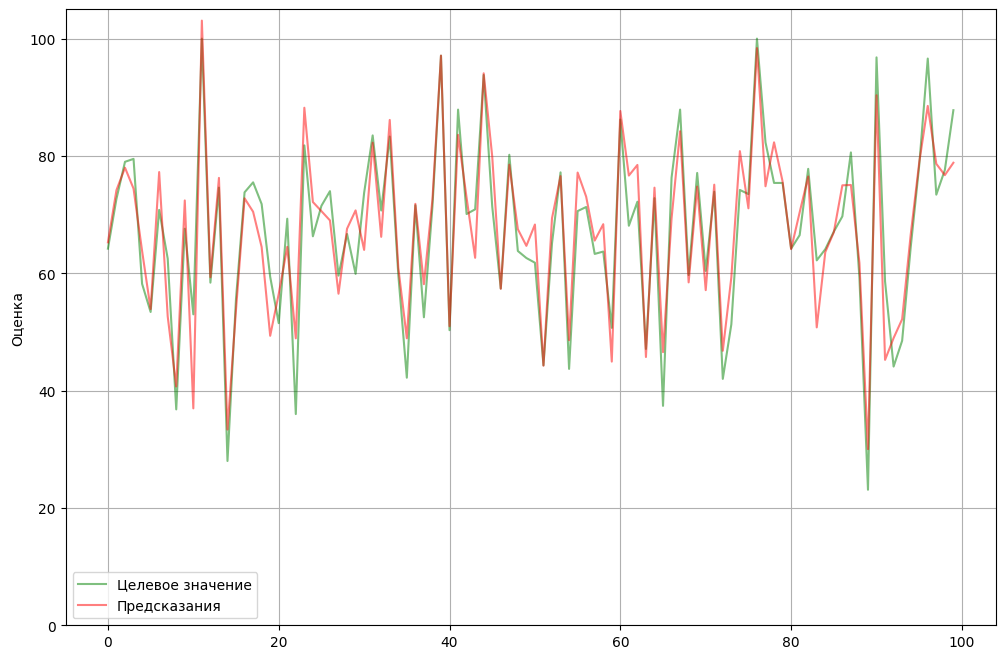

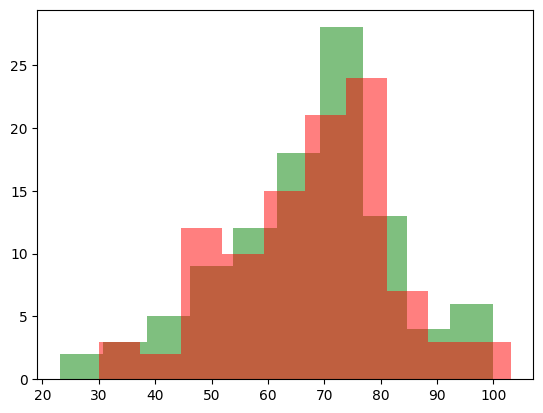

In [ ]:
model.show_results()

### В целом предсказание модели получилось достаточно точным, относительная ошибка: 0.8747%, L1: 0.5455. Графики это подтверждают